In [1]:
import xarray as xr
import numpy as np
import fsspec

from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns
import os
import dask
import importlib
import src.ExtremeWeatherBench.utils as utils
import src.ExtremeWeatherBench.events as events
import src.ExtremeWeatherBench.case as case
importlib.reload(utils)
import matplotlib.gridspec as gridspec
dask.config.set({'temporary_directory': '/mnt/disks/data/'})
sns.set_theme(style='whitegrid',context='talk')

# Load and prep datasets

In [2]:
location_center = {'latitude': 47.6062, 'longitude': -122.3321}
box_length_width_in_km = 500

In [3]:
era5 = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks='auto',
    storage_options=dict(token='anon'),
)

era5_pnw_heatwave_2021 = era5[['2m_temperature']].sel(time=slice('2021-06-22','2021-07-04'))
era5_pnw_heatwave_2021 = era5_pnw_heatwave_2021.sel(time=utils.is_6_hourly(era5_pnw_heatwave_2021['time.hour']))


era5_hourly_daily_85th_percentile = xr.open_zarr('/home/taylor/data/era5_2m_temperature_85th_by_hour_dayofyear.zarr')

era5_climatology = utils.convert_day_yearofday_to_time(era5_hourly_daily_85th_percentile, np.unique(era5_pnw_heatwave_2021.time.dt.year.values)[0])
era5_climatology = era5_climatology.rename_vars({'2m_temperature':'2m_temperature_85th_percentile'})

era5_dataset = case.Case(
    case_analysis_ds=era5_pnw_heatwave_2021,
    climatology_ds=era5_climatology,
    location_center=location_center,
    box_length_width_in_km=box_length_width_in_km
)
merged_dataset = xr.merge([era5_dataset.climatology_ds, era5_dataset.case_analysis_ds], join='inner',)
time_based_merged_dataset = merged_dataset.mean(['latitude','longitude'])


ERROR 1: PROJ: internal_proj_create_from_database: /home/taylor/anaconda3/envs/brightband/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/taylor/anaconda3/envs/brightband/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


# Visualize hottest day in ERA5 and time series of regional mean temps

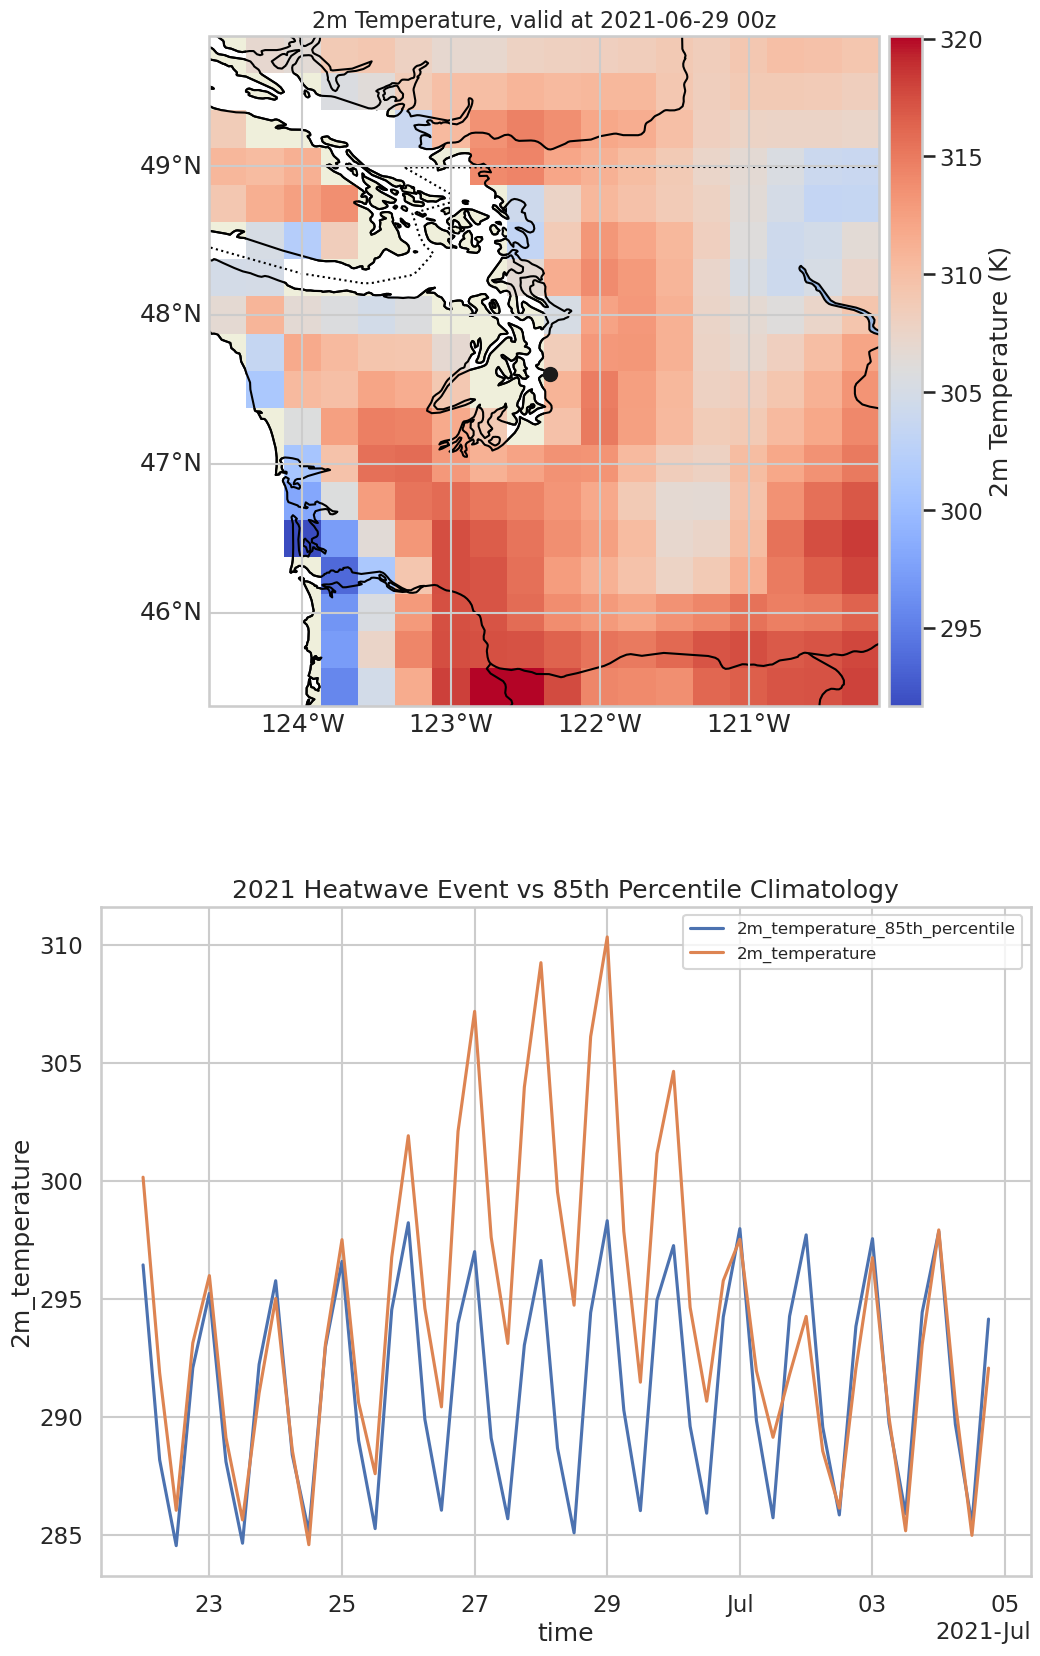

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 20), gridspec_kw={'height_ratios': [1, 1]})
plt.subplots_adjust(hspace=0.3)
ax1.remove()
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
subset_timestep = era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude', 'longitude']) == era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude', 'longitude']).max()

im = era5_dataset.case_analysis_ds['2m_temperature'].sel(time=subset_timestep).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='coolwarm', add_colorbar=False)

# Add coastlines and gridlines
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.LAKES, edgecolor='black')
ax1.add_feature(cfeature.RIVERS, edgecolor='black')
# Add gridlines
gl = ax1.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
ax1.set_title(f"2m Temperature, valid at {era5_dataset.case_analysis_ds['time'].sel(time=subset_timestep).dt.strftime('%Y-%m-%d %Hz').values[0]}", fontsize=16)
# Add the location coordinate as a dot on the map
ax1.plot(location_center['longitude'], location_center['latitude'], 'ko', markersize=10, transform=ccrs.PlateCarree())

# Create a colorbar with the same height as the plot
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
fig.colorbar(im, cax=cax, label='2m Temperature (K)')


# Merge era5_climatology with era5_case_analysis_ds
merged_dataset = xr.merge([era5_dataset.climatology_ds, era5_dataset.case_analysis_ds], join='inner')
time_based_merged_dataset = merged_dataset.mean(['latitude', 'longitude'])
for variable in time_based_merged_dataset:
    time_based_merged_dataset[variable].plot(ax=ax2, label=variable)
ax2.legend(fontsize=12)
ax2.set_title('2021 Heatwave Event vs 85th Percentile Climatology')
plt.show()

In [5]:
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=2,
    memory_limit='5GiB',
)
client = Client(cluster)

# Load in model data

In [6]:
# Note that the .nc nature of these files made it challenging initially to use this locally
# I created zarrified json reference files and put them in assets/json. The function to do this is in data_prep/convert_to_kerchunk.py and needs to be cleaned up
fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/data/forecasts/'
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

## For ERA5 comparison

In [7]:
# Initialize an empty list to store datasets
datasets = []
# Ensure fhours is part of the metadata for the data variables

for json_file in json_list:
    fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                    remote_protocol='gcs', remote_options={'anon':True})
    m = fs_.get_mapper("")
    ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
    ds = utils.convert_longitude_to_180(ds)
    ds = utils.clip_dataset_to_square(ds, location_center, box_length_width_in_km)
    ds = utils.remove_ocean_gridpoints(ds)

    model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))
    ds['init_time'] = model_run_time
    fhours = ds['time'] - model_run_time
    fhours = fhours.values / np.timedelta64(1, 'h')
    ds['fhour'] = fhours
    ds = ds.expand_dims('init_time')
    ds = ds.set_coords('init_time')
    for data_vars in ds.data_vars:
        if 'time' in ds[data_vars].dims:
            ds[data_vars] = ds[data_vars].swap_dims({'time':'fhour'})
    ds = ds.transpose('init_time', 'time', 'fhour', 'latitude', 'longitude', 'level')
    datasets.append(ds)

# Merge all datasets into a single xarray dataset
merged_forecast_ds = xr.concat(datasets, dim='init_time')
# merged_forecast_df = merged_forecast_ds.mean(['latitude','longitude'])['t2'].to_dataframe()

ERROR 1: PROJ: internal_proj_create_from_database: /home/taylor/anaconda3/envs/brightband/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
/tmp/ipykernel_16865/4197620352.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['init_time'] = model_run_time
/tmp/ipykernel_16865/4197620352.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to suppo

# Metrics (ERA5)

In [72]:
merged_forecast_ds

<xarray.Dataset> Size: 95MB
Dimensions:      (init_time: 26, fhour: 41, latitude: 18, longitude: 18,
                  level: 13, time: 91)
Coordinates:
  * latitude     (latitude) float32 72B 49.75 49.5 49.25 ... 46.0 45.75 45.5
  * time         (time) datetime64[ns] 728B 2021-06-21 ... 2021-07-13T12:00:00
  * longitude    (longitude) float32 72B -124.5 -124.2 -124.0 ... -120.5 -120.2
  * level        (level) int32 52B 1000 925 850 700 600 ... 250 200 150 100 50
  * fhour        (fhour) float64 328B 0.0 6.0 12.0 18.0 ... 228.0 234.0 240.0
  * init_time    (init_time) datetime64[ns] 208B 2021-06-21 ... 2021-07-03T12...
    spatial_ref  int64 8B 0
Data variables:
    msl          (init_time, fhour, latitude, longitude) float32 1MB dask.array<chunksize=(1, 14, 18, 18), meta=np.ndarray>
    q            (init_time, fhour, latitude, longitude, level) float32 18MB dask.array<chunksize=(1, 11, 18, 18, 3), meta=np.ndarray>
    t            (init_time, fhour, latitude, longitude, level) float32 18MB dask.array<chunksize=(1, 11, 18, 18, 3), meta=np.ndarray>
    t2           (init_time, fhour, latitude, longitude) float32 1MB dask.array<chunksize=(1, 14, 18, 18), meta=np.ndarray>
    u            (init_time, fhour, latitude, longitude, level) float32 18MB dask.array<chunksize=(1, 11, 18, 18, 3), meta=np.ndarray>
    u10          (init_time, fhour, latitude, longitude) float32 1MB dask.array<chunksize=(1, 14, 18, 18), meta=np.ndarray>
    v            (init_time, fhour, latitude, longitude, level) float32 18MB dask.array<chunksize=(1, 11, 18, 18, 3), meta=np.ndarray>
    v10          (init_time, fhour, latitude, longitude) float32 1MB dask.array<chunksize=(1, 14, 18, 18), meta=np.ndarray>
    z            (init_time, fhour, latitude, longitude, level) float32 18MB dask.array<chunksize=(1, 11, 18, 18, 3), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.8
    creation_time:         2023-11-22T05:29:06
    first_forecast_hour:   6
    forecast_hour_step:    6
    initialization_model:  GFS
    initialization_time:   2021-06-21T00:00:00
    last_forecast_hour:    240
    model_name:            Pangu-Weather
    model_version:         v1
    version:               1_2023-10-14

In [8]:
#TODO: Need to figure out how to throw these into class objects properly so its handled abstractly without an overabundance of processing

In [8]:
# Align the datasets along the 'time' dimension, adding NaNs where there aren't matching values
aligned_forecast_ds, aligned_time_based_ds = xr.align(merged_forecast_ds, merged_dataset, join='outer')
climatology_era5_forecast_merged_ds = xr.merge([aligned_forecast_ds, aligned_time_based_ds], join='inner')[['t2','2m_temperature','2m_temperature_85th_percentile']]
merged_mean_ds = climatology_era5_forecast_merged_ds.mean(['latitude','longitude'])
merged_mean_df = merged_mean_ds.to_dataframe()
forecast_df = merged_mean_ds.drop_vars(['spatial_ref','quantile'])[['t2']].to_dataframe().reset_index()
actuals_df = merged_mean_ds.drop_vars(['spatial_ref','quantile'])[['2m_temperature','2m_temperature_85th_percentile']].to_dataframe()
forecast_df['time'] = forecast_df['init_time'] + pd.to_timedelta(forecast_df['fhour'], unit='h')
merged_df = forecast_df.merge(actuals_df, left_on='time', right_index=True, how='left')

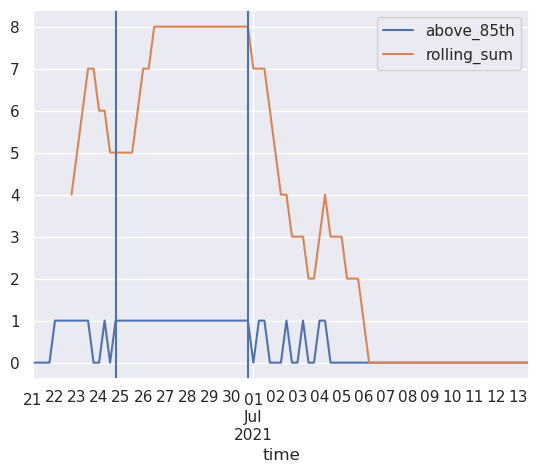

In [58]:
merged_df_for_onset.plot(x='time',y=['above_85th','rolling_sum'])
plt.axvline(merged_df_for_onset['time'].iloc[first_valid_index])
plt.axvline(merged_df_for_onset['time'].iloc[last_valid_index])

In [60]:
merged_df_for_onset = merged_df.drop_duplicates(['time','2m_temperature']).sort_values('time')
above_85th = merged_df_for_onset['2m_temperature'] > merged_df_for_onset['2m_temperature_85th_percentile']
merged_df_for_onset['above_85th'] = above_85th
merged_df_for_onset['above_85th'] = merged_df_for_onset['above_85th'].astype(int)

rolling_sum = above_85th.rolling(window=8).sum()
merged_df_for_onset['rolling_sum'] = rolling_sum
first_valid_index = rolling_sum[rolling_sum == 8].index[0] - 7 #where there's 8 consecutive hours, the onset is the first hour
last_valid_index = rolling_sum[rolling_sum == 8].index[-1]
first_valid_row = merged_df_for_onset.loc[first_valid_index]
onset = first_valid_row['time']

## Duration Above 85th Percentile ME (Region)

Text(0.5, 1.0, 'Duration of Event Error (Prior to Onset), Hours')

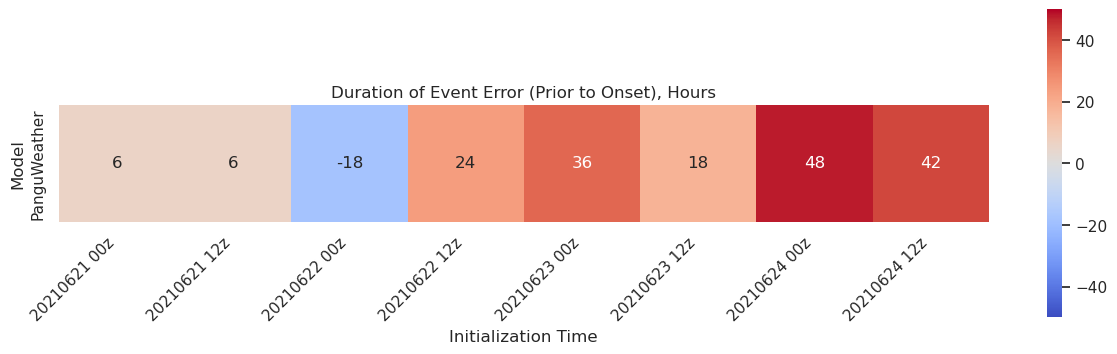

In [61]:
grouped_lengths = pd.DataFrame(merged_df[merged_df['t2'] > merged_df['2m_temperature_85th_percentile']].groupby('init_time').size()*6)
grouped_lengths['time_actuals_above_85th'] = merged_df[merged_df['2m_temperature'] > merged_df['2m_temperature_85th_percentile']].groupby('init_time').size()*6
grouped_lengths['model'] = 'PanguWeather'
grouped_lengths['duration_error'] = grouped_lengths[0] - grouped_lengths['time_actuals_above_85th']

merged_pivot = grouped_lengths[grouped_lengths.index<='2021-06-24 18'].reset_index().pivot(index='model', columns='init_time', values='duration_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=-50, vmax=50, square=True,cmap='coolwarm')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Duration of Event Error (Prior to Onset), Hours')


## Onset ME (hours)

In [62]:
merged_result_df = merged_df.merge(full_year_85th_climatology_region_df, left_on='time', right_index=True, suffixes=('', '_85th_climatology'))
merged_result_df = merged_result_df[merged_result_df['init_time']<=onset]


NameError: name 'full_year_85th_climatology_region_df' is not defined

/tmp/ipykernel_47270/433191003.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  onset_t2 = pd.DataFrame(merged_result_df.groupby('init_time').apply(onset_agg))


Text(0.5, 1.0, 'Onset Bias, Hours')

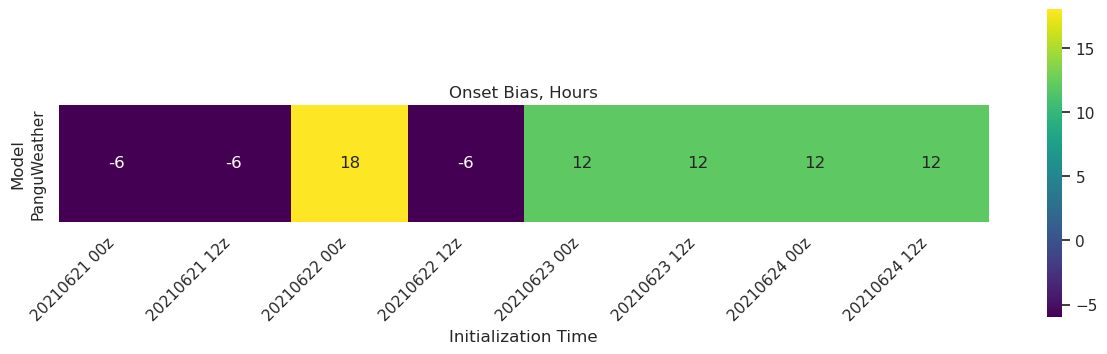

In [55]:
def onset_agg(x):
    try:
        temp_df = x.drop_duplicates(['time','2m_temperature']).sort_values('time')
        above_85th = temp_df['t2'] > temp_df['2m_temperature_85th_percentile']
        rolling_sum = above_85th.rolling(window=8).sum()
        first_valid_index = rolling_sum[rolling_sum == 8].index[0] - 8 #where there's 8 consecutive hours, the onset is the first hour
        first_valid_row = temp_df.loc[first_valid_index]
        onset = first_valid_row['time']
        return onset
    except:
        return np.nan

onset_t2 = pd.DataFrame(merged_result_df.groupby('init_time').apply(onset_agg))

onset_t2['time_error'] = (onset_t2[0] - pd.to_datetime(onset)).dt.total_seconds() / 3600 
onset_t2['model'] = 'PanguWeather'

merged_pivot = onset_t2.reset_index().pivot(index='model', columns='init_time', values='time_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, square=True,cmap='viridis')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Onset Bias, Hours')

## Max of Max Temperature Time MAE

/tmp/ipykernel_1734/1493011424.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_t2_times = merged_df.reset_index().groupby('init_time').apply(lambda x: x.loc[x['t2'].idxmax()])


Text(0.5, 1.0, 'Maximum Temperature of Event Time MAE, Hours')

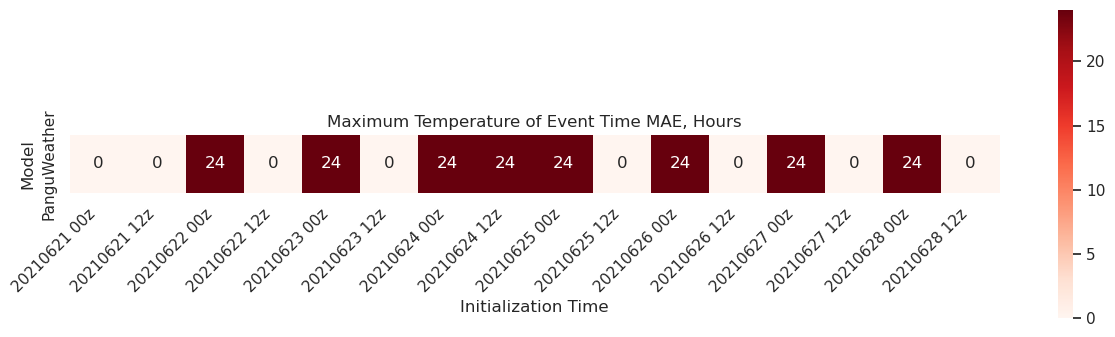

In [42]:
max_t2_times = merged_df.reset_index().groupby('init_time').apply(lambda x: x.loc[x['t2'].idxmax()])
max_t2_times['model'] = 'PanguWeather'
max_t2_times = max_t2_times[max_t2_times.index < era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values]
max_t2_times['time_error'] = abs(max_t2_times['time'] - era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values) / np.timedelta64(1, 'h')
merged_pivot = max_t2_times.pivot(index='model', columns='init_time', values='time_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, square=True,cmap='Reds')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Maximum Temperature of Event Time MAE, Hours')

## Max of Daily Min Temperature Time MAE

Text(0.5, 1.0, 'Highest Min Temp Time MAE, Hours')

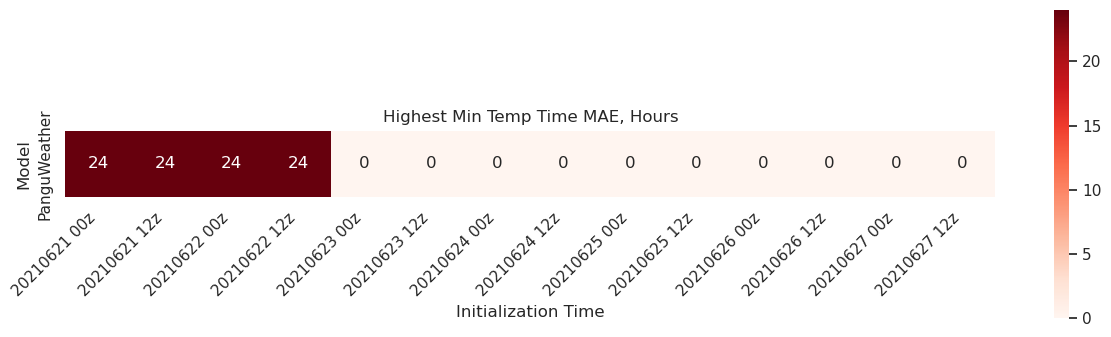

In [41]:
actuals_daily_min = actuals_df.groupby(actuals_df.index.date)['2m_temperature'].min()
max_of_min_t2_time = actuals_daily_min.idxmax()

grouped = merged_df.groupby(['init_time', merged_df['time'].dt.date])
# Filter groups to only include those with 4 timestamps
filtered_groups = grouped.filter(lambda x: len(x) == 4)
max_min_temp = filtered_groups.groupby(['init_time', filtered_groups['time'].dt.date]).min()
max_min_temp_indexes = max_min_temp.groupby('init_time')['t2'].idxmax()
max_min_temp = max_min_temp.loc[max_min_temp_indexes]
max_min_temp['time_error'] = abs(max_min_temp['time'] - pd.to_datetime(actuals_daily_min.idxmax())) / np.timedelta64(1, 'h')

max_min_temp['t2_mae'] = abs(max_min_temp['t2'] - actuals_daily_min.max())
max_min_temp['model'] = 'PanguWeather'
max_min_temp = max_min_temp.drop('time',axis=1).reset_index()
merged_pivot = max_min_temp[max_min_temp['init_time']<pd.to_datetime(max_of_min_t2_time)].pivot(index='model', columns='init_time', values='time_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, square=True,cmap='Reds')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Highest Min Temp Time MAE, Hours')

## Max of Max Temperature MAE

/tmp/ipykernel_16865/3689280104.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_t2_times = merged_df.reset_index().groupby('init_time').apply(lambda x: x.loc[x['t2'].idxmax()])


Text(0.5, 1.0, 'Maximum Temperature of Event MAE, C')

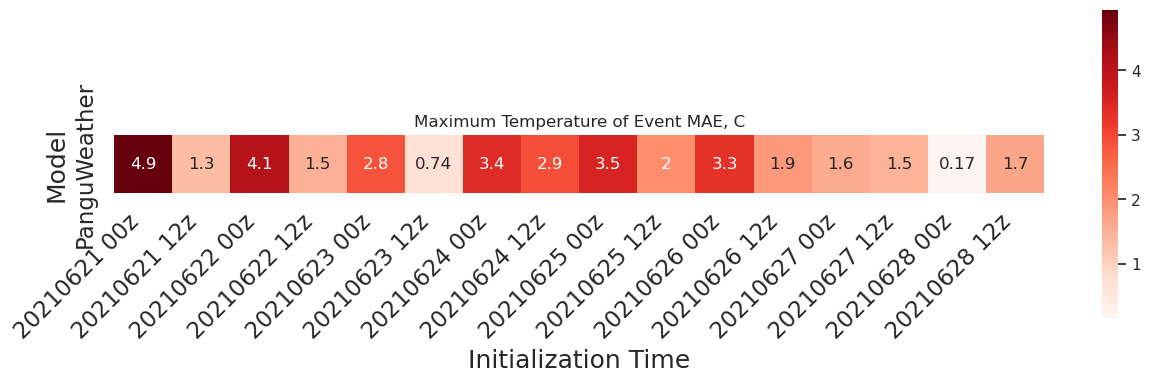

In [10]:
max_t2_times = merged_df.reset_index().groupby('init_time').apply(lambda x: x.loc[x['t2'].idxmax()])
max_t2_times['model'] = 'PanguWeather'
max_t2_times = max_t2_times[max_t2_times.index < era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values]
max_t2_times['time_error'] = abs(max_t2_times['time'] - era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values) / np.timedelta64(1, 'h')
max_t2_times['t2_mae'] = abs(max_t2_times['t2'] - era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).max().values)
merged_pivot = max_t2_times.pivot(index='model', columns='init_time', values='t2_mae')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, square=True,cmap='Reds')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Maximum Temperature of Event MAE, C')

## Max of Daily Min Temperatures MAE

/tmp/ipykernel_16865/2581786995.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forecast_daily_min = forecast_daily_min.groupby('init_time').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)


Text(0.5, 1.0, 'Highest Min Temp MAE, C')

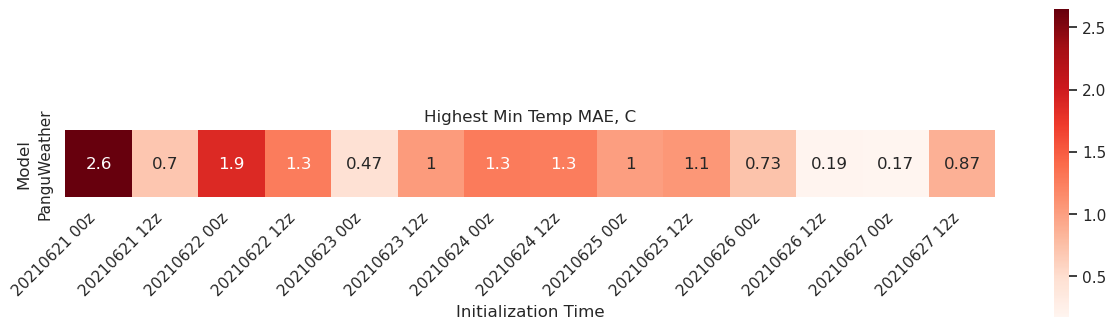

In [11]:
# Calculate the daily minimum temperatures for both forecast and actuals
forecast_daily_min = merged_df.groupby(['init_time',merged_df['time'].dt.date])['t2'].min().reset_index()
forecast_daily_min = forecast_daily_min.groupby('init_time').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
forecast_daily_min['time'] = pd.to_datetime(forecast_daily_min['time'])
actuals_daily_min = actuals_df.groupby(actuals_df.index.date)['2m_temperature'].min()

# Calculate the error of the maximum of daily minimum temperatures
max_of_min_t2_time = actuals_daily_min.idxmax()
forecast_daily_min = forecast_daily_min.groupby('init_time').max().reset_index()
forecast_daily_min['t2_mae'] = abs(forecast_daily_min['t2'] - actuals_daily_min.max())
forecast_daily_min['model'] = 'PanguWeather'
merged_pivot = forecast_daily_min[forecast_daily_min['init_time']<pd.to_datetime(max_of_min_t2_time)].pivot(index='model', columns='init_time', values='t2_mae')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, square=True,cmap='Reds')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Highest Min Temp MAE, C')

## Regional RMSE

/tmp/ipykernel_20396/2857289336.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_fhour = merged_result_df.dropna().groupby('fhour').apply(lambda x: np.sqrt(mean_squared_error(x['2m_temperature'], x['t2'])))


Text(0.0, 1.0, 'Regional RMSE by Forecast Hour')

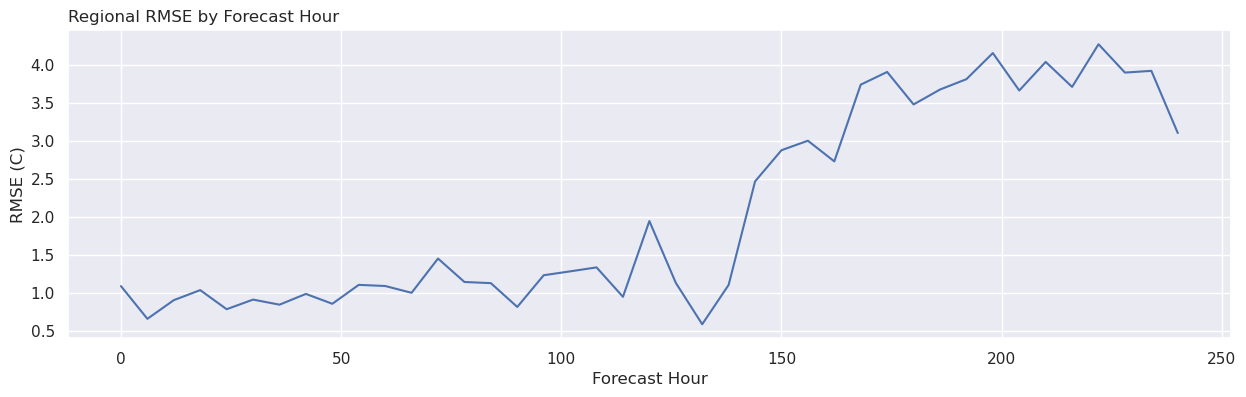

In [441]:
from sklearn.metrics import mean_squared_error

rmse_by_fhour = merged_result_df.dropna().groupby('fhour').apply(lambda x: np.sqrt(mean_squared_error(x['2m_temperature'], x['t2'])))
fig, ax = plt.subplots(figsize=(15,4))
rmse_by_fhour.plot(ax=ax)
ax.set_ylabel('RMSE (C)')
ax.set_xlabel('Forecast Hour')
ax.set_title('Regional RMSE by Forecast Hour',loc='left')
# np.sqrt(mean_squared_error(merged_result_df.dropna()['2m_temperature'],merged_result_df.dropna()['t2']))

# Metrics (Obs)

In [ ]:
data = merged_forecast_df.pivot_table(index='init_time',columns='fhour',values='t2')
plt.figure(figsize=(15, 10))
sns.heatmap(data, cmap='Reds', cbar_kws={'label': 'Temperature (K)'})
plt.gca().invert_yaxis()
# Improve the appearance of the x and y ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.xlabel('Forecast Hour', fontsize=14)
plt.ylabel('Initialization Time', fontsize=14)
plt.title('Temperature Forecast Heatmap', fontsize=16)
plt.show()

In [ ]:
mask = (time_based_merged_dataset['2m_temperature'] > time_based_merged_dataset['2m_temperature_85th_percentile']).rolling(time=24, min_periods=4).sum() > 4
sns.heatmap(mask.rename('heatwave_mask').to_dataframe().reset_index().pivot(index='time',values='heatwave_mask',columns='spatial_ref'))

In [ ]:
merged_mean_df['t2_heat_wave_boolean'] = (merged_mean_df['t2'] > merged_mean_df['2m_temperature_85th_percentile'])
merged_mean_df['2m_temperature_heat_wave_boolean'] = (merged_mean_df['2m_temperature'] > merged_mean_df['2m_temperature_85th_percentile'])

In [223]:
merged_mean_df.groupby(['init_time', 'time']).agg({
    't2': 'first',
    '2m_temperature': 'first',
    '2m_temperature_85th_percentile': 'first',
    'spatial_ref': 'first',
    'quantile': 'first',
    't2_heat_wave_boolean': 'max',
    '2m_temperature_heat_wave_boolean': 'max'
})

t2  2m_temperature  \
init_time           time                                              
2021-06-21 00:00:00 2021-06-21 00:00:00  298.577728             NaN   
                    2021-06-21 06:00:00  298.577728             NaN   
                    2021-06-21 12:00:00  298.577728             NaN   
                    2021-06-21 18:00:00  298.577728             NaN   
                    2021-06-22 00:00:00  298.577728             NaN   
...                                             ...             ...   
2021-07-03 12:00:00 2021-07-12 12:00:00  285.306519             NaN   
                    2021-07-12 18:00:00  285.306519             NaN   
                    2021-07-13 00:00:00  285.306519             NaN   
                    2021-07-13 06:00:00  285.306519             NaN   
                    2021-07-13 12:00:00  285.306519             NaN   

                                         2m_temperature_85th_percentile  \
init_time           time                                                  
2021-06-21 00:00:00 2021-06-21 00:00:00                             NaN   
                    2021-06-21 06:00:00                             NaN   
                    2021-06-21 12:00:00                             NaN   
                    2021-06-21 18:00:00                             NaN   
                    2021-06-22 00:00:00                             NaN   
...                                                                 ...   
2021-07-03 12:00:00 2021-07-12 12:00:00                             NaN   
                    2021-07-12 18:00:00                             NaN   
                    2021-07-13 00:00:00                             NaN   
                    2021-07-13 06:00:00                             NaN   
                    2021-07-13 12:00:00                             NaN   

                                         spatial_ref  quantile  \
init_time           time                                         
2021-06-21 00:00:00 2021-06-21 00:00:00            0      0.85   
                    2021-06-21 06:00:00            0      0.85   
                    2021-06-21 12:00:00            0      0.85   
                    2021-06-21 18:00:00            0      0.85   
                    2021-06-22 00:00:00            0      0.85   
...                                              ...       ...   
2021-07-03 12:00:00 2021-07-12 12:00:00            0      0.85   
                    2021-07-12 18:00:00            0      0.85   
                    2021-07-13 00:00:00            0      0.85   
                    2021-07-13 06:00:00            0      0.85   
                    2021-07-13 12:00:00            0      0.85   

                                         t2_heat_wave_boolean  \
init_time           time                                        
2021-06-21 00:00:00 2021-06-21 00:00:00                 False   
                    2021-06-21 06:00:00                 False   
                    2021-06-21 12:00:00                 False   
                    2021-06-21 18:00:00                 False   
                    2021-06-22 00:00:00                 False   
...                                                       ...   
2021-07-03 12:00:00 2021-07-12 12:00:00                 False   
                    2021-07-12 18:00:00                 False   
                    2021-07-13 00:00:00                 False   
                    2021-07-13 06:00:00                 False   
                    2021-07-13 12:00:00                 False   

                                         2m_temperature_heat_wave_boolean  
init_time           time                                                   
2021-06-21 00:00:00 2021-06-21 00:00:00                             False  
                    2021-06-21 06:00:00                             False  
                    2021-06-21 12:00:00                             False  
                    2021-06-21 18:00:00                         

In [210]:
merged_mean_df.drop_duplicates(subset=['init_time','fhour'])['t2_heat_wave_boolean'].sum()

0

In [194]:
# mask = (merged_mean_ds['2m_temperature'] > merged_mean_ds['2m_temperature_85th_percentile']).rolling(time=4, min_periods=4).sum() > 4
# sns.heatmap(mask.rename('heatwave_mask').to_dataframe().reset_index().pivot(index='time',values='heatwave_mask',columns='spatial_ref'))

In [29]:
merged_df['hour_of_day'] = merged_df['time'].dt.hour
merged_df['t2_anomaly'] = merged_df.apply(lambda row: row['t2'] - merged_df[merged_df['hour_of_day'] == row['hour_of_day']]['t2'].mean(), axis=1)

In [64]:
merged_df['t2_error'] = merged_df['t2'] - merged_df['2m_temperature']

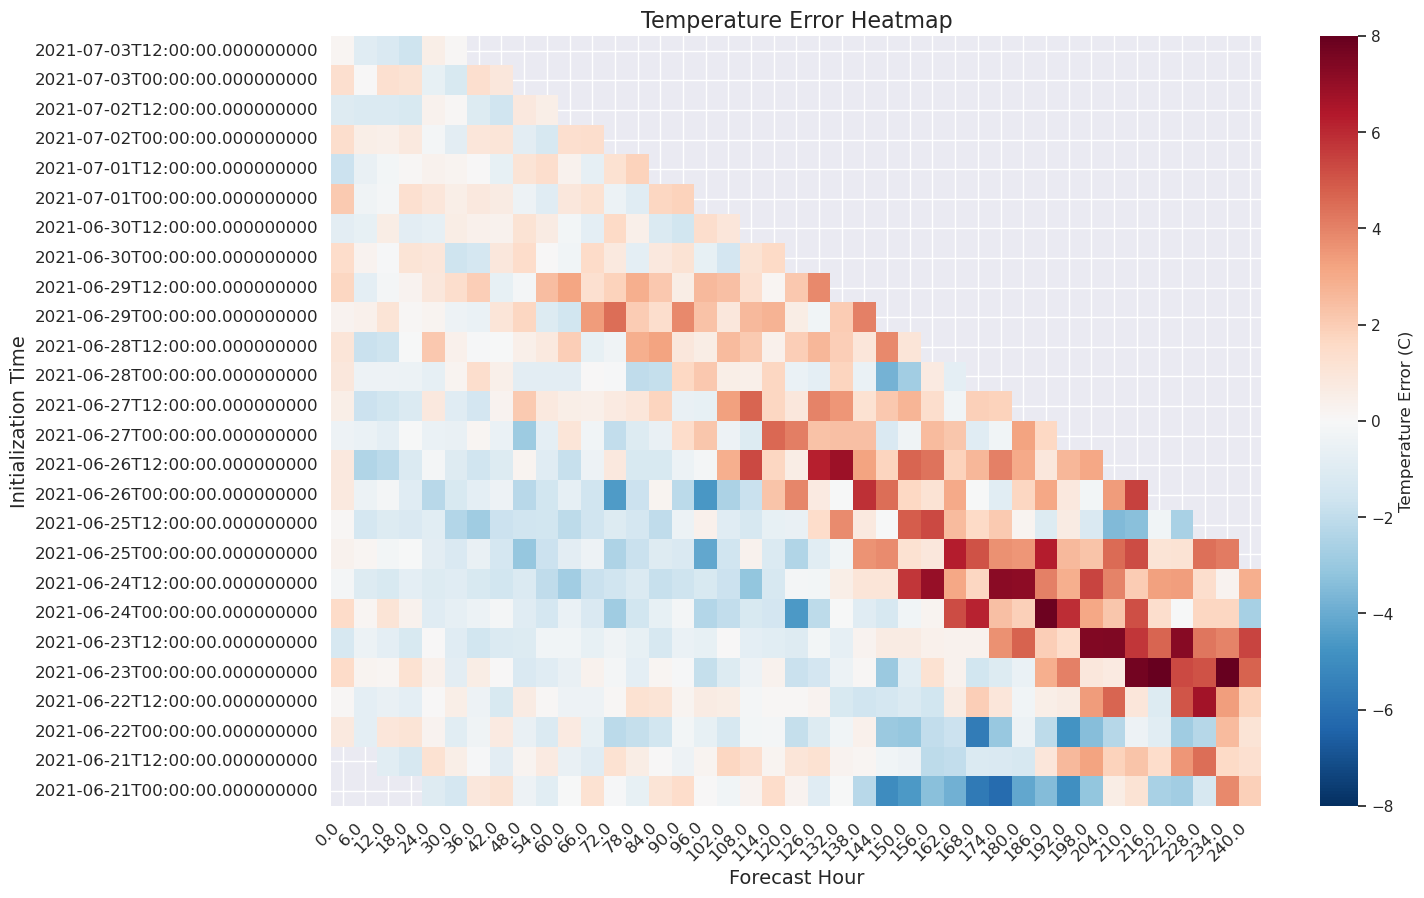

In [71]:

data = merged_df.pivot_table(index='init_time',columns='fhour',values='t2_error')
plt.figure(figsize=(15, 10))
sns.heatmap(data, cmap='RdBu_r', cbar_kws={'label': 'Temperature Error (C)'},vmin=-8,vmax=8)
# Add black outline for boxes where 2m_temperature is greater than 2m_temperature_85th_percentile
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         if merged_df[(merged_df['init_time'] == data.index[i]) & (merged_df['fhour'] == data.columns[j])]['2m_temperature'].values[0] > merged_df[(merged_df['init_time'] == data.index[i]) & (merged_df['fhour'] == data.columns[j])]['2m_temperature_85th_percentile'].values[0]:
#             plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1))
cbar = plt.gca().collections[0].colorbar
# cbar.set_ticks([10, 20, 30, 40, 50])
# cbar.set_ticklabels([10, 20, 30, 40, 50])
plt.gca().invert_yaxis()
# Improve the appearance of the x and y ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.xlabel('Forecast Hour', fontsize=14)
plt.ylabel('Initialization Time', fontsize=14)
plt.title('Temperature Error Heatmap', fontsize=16)
plt.show()

In [ ]:
# Calculate the number of hours above the 85th percentile for observations
obs_hours_above_85th = (era5_dataset.case_analysis_ds['2m_temperature'] > era5_dataset.climatology_ds['2m_temperature_85th_percentile']).resample(time='1D').sum()

# Calculate the number of hours above the 85th percentile for forecasts
forecast_hours_above_85th = (merged_forecast_ds['t2'] > era5_dataset.climatology_ds['2m_temperature_85th_percentile']).resample(time='1D').sum()

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=forecast_hours_above_85th['time'].dt.date, columns=forecast_hours_above_85th['init_time'].dt.strftime('%Y-%m-%d %Hz'))

# Fill the DataFrame with the results
for init_time in forecast_hours_above_85th['init_time'].values:
    for forecast_day in forecast_hours_above_85th['time'].dt.date.values:
        obs_condition = obs_hours_above_85th.sel(time=str(forecast_day)).values >= 24
        forecast_condition = forecast_hours_above_85th.sel(time=str(forecast_day), init_time=init_time).values >= 24
        if obs_condition and forecast_condition:
            results_df.loc[forecast_day, pd.to_datetime(init_time).strftime('%Y-%m-%d %Hz')] = 1
        elif obs_condition:
            results_df.loc[forecast_day, pd.to_datetime(init_time).strftime('%Y-%m-%d %Hz')] = 0.5
        elif forecast_condition:
            results_df.loc[forecast_day, pd.to_datetime(init_time).strftime('%Y-%m-%d %Hz')] = -1
        else:
            results_df.loc[forecast_day, pd.to_datetime(init_time).strftime('%Y-%m-%d %Hz')] = 0

# Plot the heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(results_df.astype(float), cmap='coolwarm', cbar=False, ax=ax, linewidths=0.5, linecolor='black')

# Add hatching for the observations
for i in range(results_df.shape[0]):
    for j in range(results_df.shape[1]):
        if results_df.iloc[i, j] == 0.5:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='//', edgecolor='black'))

# Set axis labels and title
ax.set_xlabel('Initialization Time')
ax.set_ylabel('Forecast Day')
ax.set_title('Heatmap of Forecast and Observed Temperatures Above 85th Percentile')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

ValueError: cannot reindex or align along dimension 'time' because the (pandas) index has duplicate values

Text(0.5, 1.0, 'Maximum Temperature of Event Error')

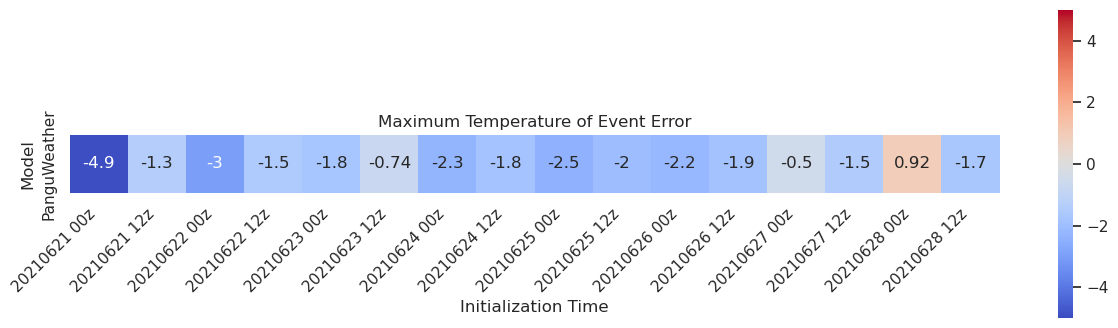

In [ ]:
max_t2_times = merged_combined_df.reset_index().groupby('init_time').apply(lambda x: x.loc[x['t2'].idxmax()])
max_t2_times['model'] = 'PanguWeather'
max_t2_times = max_t2_times[max_t2_times.index < era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values]
max_t2_times['time_error'] = max_t2_times['time'] - era5_dataset.case_analysis_ds['time'][era5_dataset.case_analysis_ds['2m_temperature'].mean(['latitude','longitude']).argmax().values].values
max_t2_times['max_t2_error'] = max_t2_times['t2'] - max_t2_times['2m_temperature']
merged_pivot = max_t2_times.pivot(index='model', columns='init_time', values='max_t2_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=-5, vmax=5, square=True,cmap='coolwarm')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Maximum Temperature of Event Error')

Text(0.5, 1.0, 'Duration of Event Error (Prior to Onset), Hours')

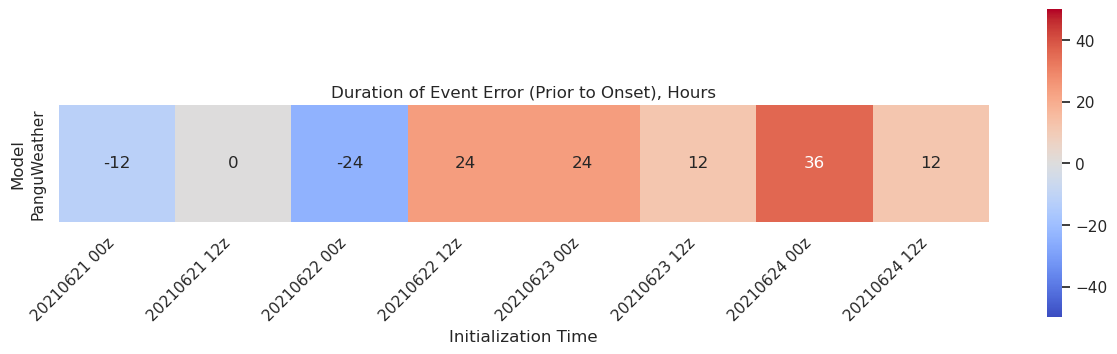

In [214]:
grouped_lengths = pd.DataFrame(merged_combined_df[merged_combined_df['t2'] > merged_combined_df['2m_temperature_85th_percentile']].groupby('init_time').size()*6)
grouped_lengths['model'] = 'PanguWeather'
grouped_lengths['duration_error'] = grouped_lengths[0] - hours_above_85th_percentile_era5

merged_pivot = grouped_lengths[grouped_lengths.index<='2021-06-24 18'].reset_index().pivot(index='model', columns='init_time', values='duration_error')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=-50, vmax=50, square=True,cmap='coolwarm')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Model')
ax.set_xlabel('Initialization Time')
ax.set_title('Duration of Event Error (Prior to Onset), Hours')



## For obs comparison

<Axes: xlabel='spatial_ref', ylabel='time'>

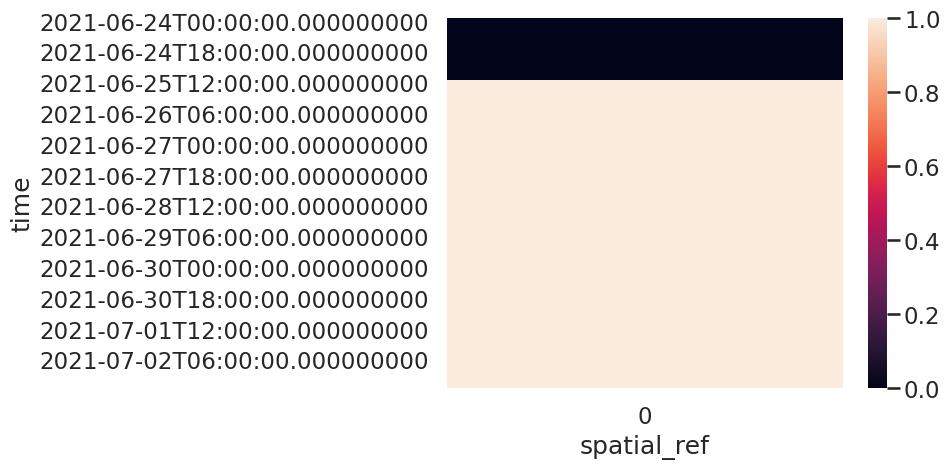

In [6]:
mask = (time_based_merged_dataset['2m_temperature'] > time_based_merged_dataset['2m_temperature_85th_percentile']).rolling(time=24, min_periods=4).sum() > 4
sns.heatmap(mask.rename('heatwave_mask').to_dataframe().reset_index().pivot(index='time',values='heatwave_mask',columns='spatial_ref'))

In [ ]:
# Note that the .nc nature of these files made it challenging initially to use this locally but should arguably be quicker with an xr.open_mfdataset... but in the meantime
# I created zarrified json reference files and put them in assets/json. The function to do this is in data_prep/convert_to_kerchunk.py and needs to be cleaned up

fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/json/'
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

#point obs locations, seatac, bellingham, vancouver, lytton
ksea_coords = (47.44469, -122.31437)
kbli_coords = (48.79269, -122.53753)
cyvr_coords = (49.18303, -123.16823)
cwly_coords = (50.22448, -121.58180)

point_df = pd.DataFrame(
    {
    "longitude": [n[1] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "latitude": [n[0] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "name": ['KSEA', 'KBLI', 'CYVR', 'CWLY']
    }
)

if os.path.exists('assets/data/asos_pangu.csv'):
    asos_pang_df = pd.read_csv('assets/data/asos_pangu.csv')
    asos_pang_df['time'] = pd.to_datetime(asos_pang_df['time'])
    if 't2c' not in asos_pang_df.columns:
        asos_pang_df['t2c'] = asos_pang_df['t2'] - 273.15
        asos_pang_df['init_time'] = pd.to_datetime(asos_pang_df['init_time'])
else:
    asos_pang_df = pd.DataFrame()
    for json_file in json_list:
        fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                        remote_protocol='gcs', remote_options={'anon':True})
        m = fs_.get_mapper("")
        ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
        locations_df = pd.DataFrame()
        for i, row in point_df.iterrows():
            model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))

            fhours = ds['time'] - model_run_time
            fhours = fhours.values/ np.timedelta64(1, 'h')
            df = ds['t2'].sel(longitude=convert_longitude_to_360(row['longitude']),latitude=row['latitude'],method='nearest').to_dataframe()
            df['stationid'] = row['name']
            df['fhour'] = fhours
            df['init_time'] = model_run_time
            locations_df = pd.concat([df,locations_df])
        asos_pang_df['t2c'] = asos_pang_df['t2'] - 273.15
        asos_pang_df = pd.concat([asos_pang_df,locations_df])
    asos_pang_df.to_csv('assets/data/asos_pangu.csv')

# Load in obs

In [ ]:
#point obs locations, seatac, bellingham, vancouver, lytton
ksea_coords = (47.44469, -122.31437)
kbli_coords = (48.79269, -122.53753)
cyvr_coords = (49.18303, -123.16823)
cwly_coords = (50.22448, -121.58180)

point_df = pd.DataFrame(
    {
    "longitude": [n[1] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "latitude": [n[0] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "name": ['KSEA', 'KBLI', 'CYVR', 'CWLY']
    }
)

In [5]:
ksea_event_df = pd.read_csv(f'assets/data/KSEA_event.csv').dropna()
ksea_event_df['valid'] = pd.to_datetime(ksea_event_df['valid'])
ksea_event_df['tmpc'] = ksea_event_df['tmpc'].astype(float)
ksea_event_df = ksea_event_df.set_index('valid')
ksea_event_df = ksea_event_df.resample('h').mean(numeric_only=True)
ksea_event_df = ksea_event_df[['tmpc']]
ksea_event_df['stationid'] = 'KSEA'

In [19]:
climatology_dict = {}
climatology_dict['KSEA'] = {}
climatology_dict['KBLI'] = {}
climatology_dict['CYVR'] = {}
climatology_dict['CWLY'] = {}

for station in climatology_dict.items():
    station[1]['data'] = pd.read_csv(f'assets/data/{station[0]}.csv').dropna()
    station[1]['data']['valid'] = pd.to_datetime(station[1]['data']['valid'])
    station[1]['data']['tmpc'] = station[1]['data']['tmpc'].astype(float)
    station[1]['data'] = station[1]['data'].set_index('valid')
    station[1]['data'] = station[1]['data'].resample('h').mean(numeric_only=True)
    station[1]['data']['stationid'] = station[0]
    station[1]['data'] = station[1]['data'].resample('6h').first(numeric_only=True)
    station[1]['85th_percentile_climatology'] = station[1]['data'].groupby([station[1]['data'].index.month, station[1]['data'].index.day, station[1]['data'].index.hour])['tmpc'].transform(lambda x: np.nanpercentile(x, 85))
    # Extract month, day, and hour from the index of '85th_percentile_climatology' in climatology_dict['KSEA']
    station[1]['85th_percentile_climatology'] = station[1]['85th_percentile_climatology'].reset_index()
    station[1]['85th_percentile_climatology']['month_day_hour'] = station[1]['85th_percentile_climatology']['valid'].dt.strftime('%m-%d %H')
    

In [46]:
if os.path.exists('assets/data/asos_pangu.csv'):
    asos_pang_df = pd.read_csv('assets/data/asos_pangu.csv')
    asos_pang_df['time'] = pd.to_datetime(asos_pang_df['time'])
    if 't2c' not in asos_pang_df.columns:
        asos_pang_df['t2c'] = asos_pang_df['t2'] - 273.15
        asos_pang_df['init_time'] = pd.to_datetime(asos_pang_df['init_time'])
else:
    asos_pang_df = pd.DataFrame()
    for json_file in json_list:
        fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                        remote_protocol='gcs', remote_options={'anon':True})
        m = fs_.get_mapper("")
        ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
        locations_df = pd.DataFrame()
        for i, row in point_df.iterrows():
            model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))

            fhours = ds['time'] - model_run_time
            fhours = fhours.values/ np.timedelta64(1, 'h')
            df = ds['t2'].sel(longitude=convert_longitude_to_360(row['longitude']),latitude=row['latitude'],method='nearest').to_dataframe()
            df['stationid'] = row['name']
            df['fhour'] = fhours
            df['init_time'] = model_run_time
            locations_df = pd.concat([df,locations_df])
        asos_pang_df['t2c'] = asos_pang_df['t2'] - 273.15
        asos_pang_df = pd.concat([asos_pang_df,locations_df])
    asos_pang_df.to_csv('assets/data/asos_pangu.csv')

Text(0.5, 1.0, 'KSEA 85th Percentile Climatology')

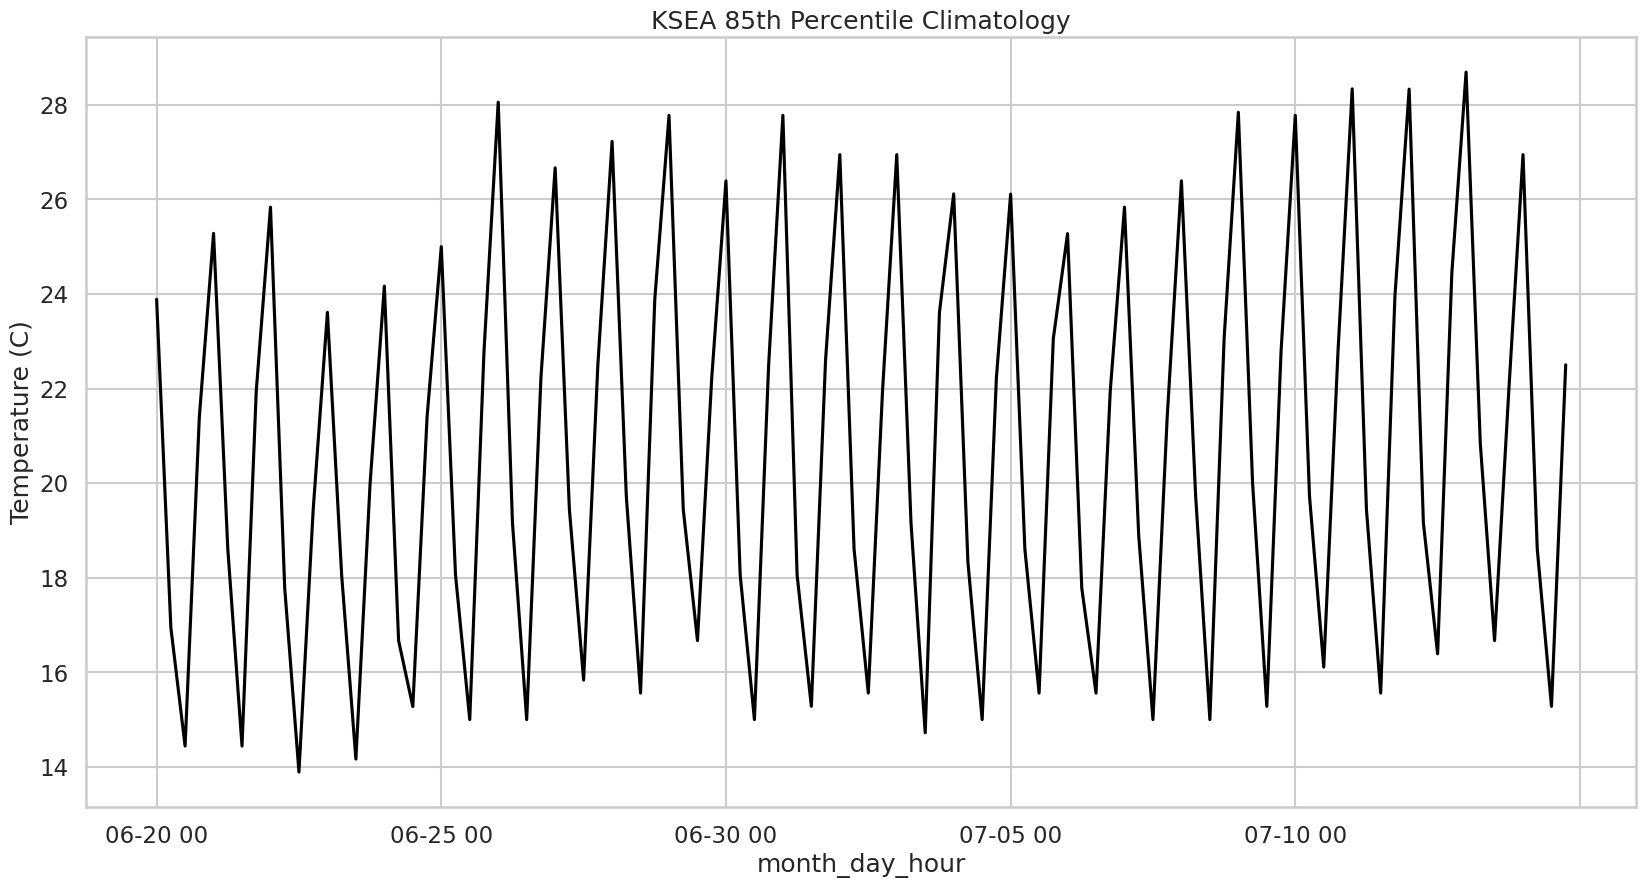

In [47]:
climatology_dict['KSEA']['85th_percentile_climatology'].iloc[680:780].plot(figsize=(20,10),legend=False,x='month_day_hour', y='tmpc', label='Observed 85th Percentile Climatology', color='black')
plt.ylabel('Temperature (C)')
plt.title('KSEA 85th Percentile Climatology')

In [52]:
# 3 datasets as of this point: climatology_dict, the ksea_event_df, and the asos_pang_df for the forecasts. Need to merge the event and ksea_event_df

ksea_merged_df = asos_pang_df.reset_index().rename(columns={'time':'valid'}).merge(ksea_event_df.reset_index(),on=['stationid','valid'])
ksea_merged_df = ksea_merged_df[ksea_merged_df['fhour']>=0]

In [56]:
ksea_merged_df

,index,valid,latitude,longitude,t2,stationid,fhour,init_time,t2c,tmpc,month_day_hour,tmpc_85th_percentile
0,123,2021-06-21 00:00:00,47.5,237.75,300.27658,KSEA,0.0,2021-06-21 00:00:00,27.12658,27.220000,06-21 00,25.280
31,124,2021-06-21 06:00:00,47.5,237.75,293.15503,KSEA,6.0,2021-06-21 00:00:00,20.00503,20.560000,06-21 06,18.610
62,125,2021-06-21 12:00:00,47.5,237.75,289.55127,KSEA,12.0,2021-06-21 00:00:00,16.40127,18.330000,06-21 12,14.440
93,126,2021-06-21 18:00:00,47.5,237.75,297.51520,KSEA,18.0,2021-06-21 00:00:00,24.36520,26.110000,06-21 18,21.945
124,127,2021-06-22 00:00:00,47.5,237.75,302.00930,KSEA,24.0,2021-06-21 00:00:00,28.85930,31.110000,06-22 00,25.835
...,...,...,...,...,...,...,...,...,...,...,...,...
32891,4259,2021-07-12 12:00:00,47.5,237.75,291.29153,KSEA,216.0,2021-07-03 12:00:00,18.14153,12.780000,07-12 12,16.390
32922,4260,2021-07-12 18:00:00,47.5,237.75,300.01514,KSEA,222.0,2021-07-03 12:00:00,26.86514,21.670000,07-12 18,24.445
32953,4261,2021-07-13 00:00:00,47.5,237.75,303.31104,KSEA,228.0,2021-07-03 12:00:00,30.16104,26.670000,07-13 00,28.690
32984,4262,2021-07-13 06:00:00,47.5,237.75,294.71118,KSEA,234.0,2021-07-03 12:00:00,21.56118,18.330000,07-13 06,20.835


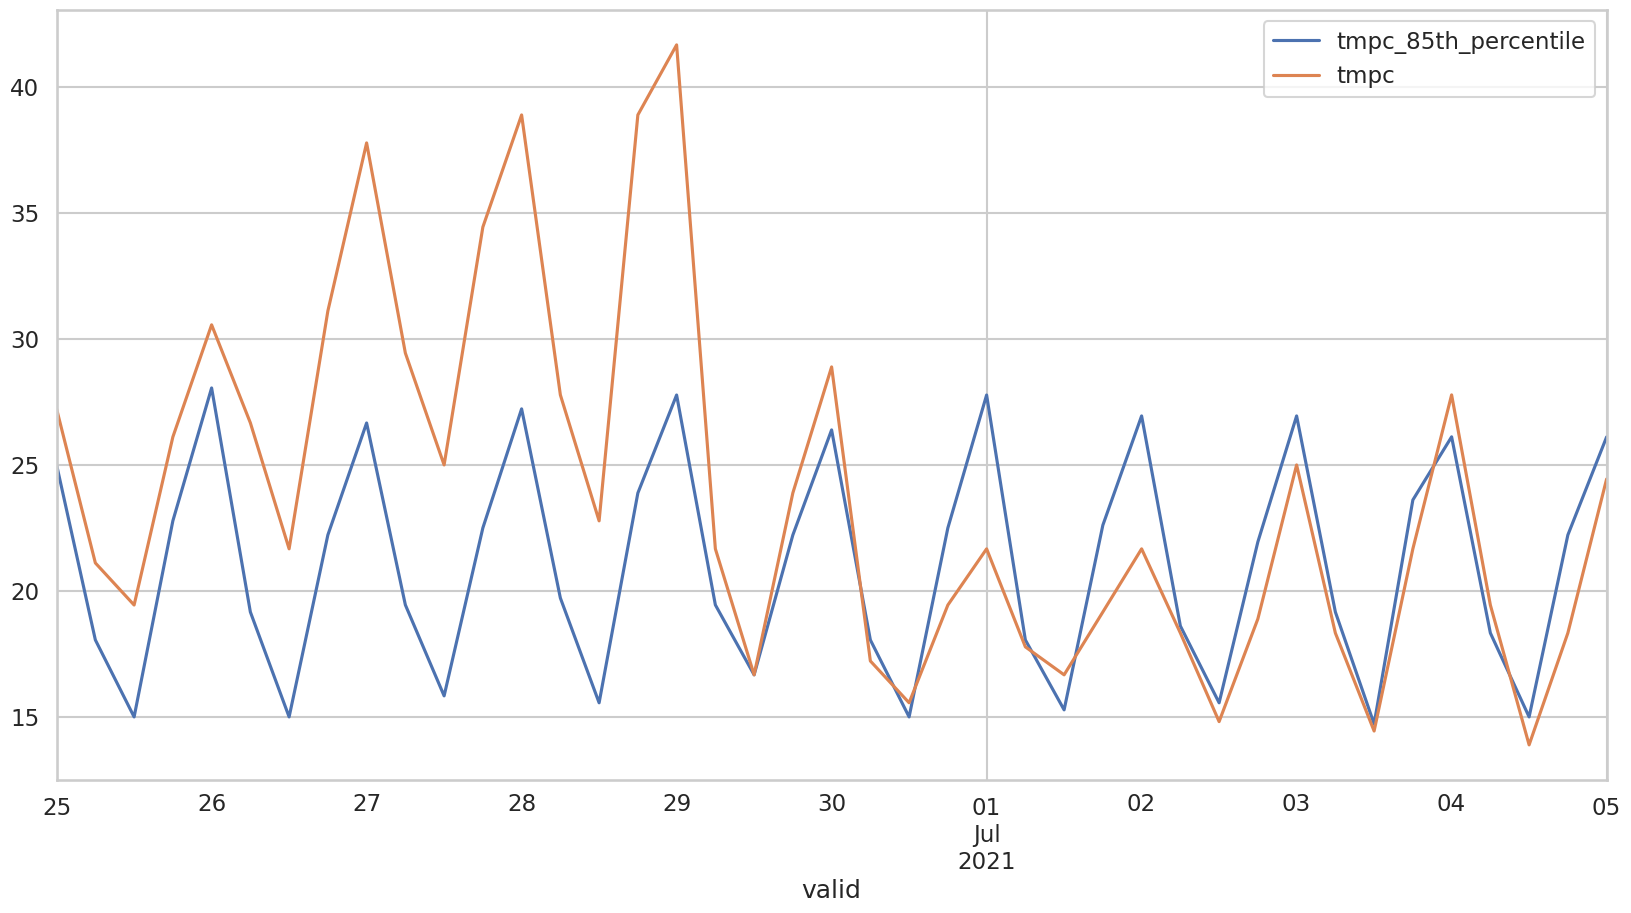

In [55]:
# merge the 85th percentile climatology with the merged df
# Extract month, day, and hour from 'valid' datetime in ksea_merged_df
ksea_merged_df['month_day_hour'] = ksea_merged_df['valid'].dt.strftime('%m-%d %H')

# Merge on 'month_day_hour'
ksea_merged_df = ksea_merged_df.merge(climatology_dict['KSEA']['85th_percentile_climatology'][['month_day_hour', 'tmpc']], on='month_day_hour', suffixes=('', '_85th_percentile'))
ksea_merged_df = ksea_merged_df.drop_duplicates(subset=['valid','init_time'], keep='first')

#plot
ksea_merged_df[ksea_merged_df['init_time']=='2021-06-25'].plot(y=['tmpc_85th_percentile','tmpc'], x='valid', figsize=(20,10))
plt.show()

# Duration MAE and ME

In [ ]:
# Convert 'valid' to datetime if not already
ksea_merged_df['valid'] = pd.to_datetime(ksea_merged_df['valid'])

# Filter the dataframe for dates after June 24 - event start date - 2 days
filtered_df = ksea_merged_df[ksea_merged_df['valid'] > '2021-06-24']


# Group by 'init_time' and find the first 'valid' where 't2c' is greater than 'tmpc_85th_percentile'
result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']].iloc[0])
result = result[result['init_time'] <= '2021-06-26']

# Reset index to get a clean dataframe
result = result.reset_index(drop=True)
# Find the first time ksea_event_df's 'tmpc' was greater than 'tmpc_85th_percentile'
first_exceedance_time = ksea_merged_df[(ksea_merged_df['tmpc'] > ksea_merged_df['tmpc_85th_percentile']) & (ksea_merged_df['valid']>='2021-06-24')].min()['valid']   

# Ensure first_exceedance_time is a Timestamp object
first_exceedance_time = pd.to_datetime(first_exceedance_time)

# Calculate the time difference and create the 'begin_error' column
result['begin_error'] = result['valid'] - first_exceedance_time



/tmp/ipykernel_2302/3180808072.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']].iloc[0])


<Axes: xlabel='valid'>

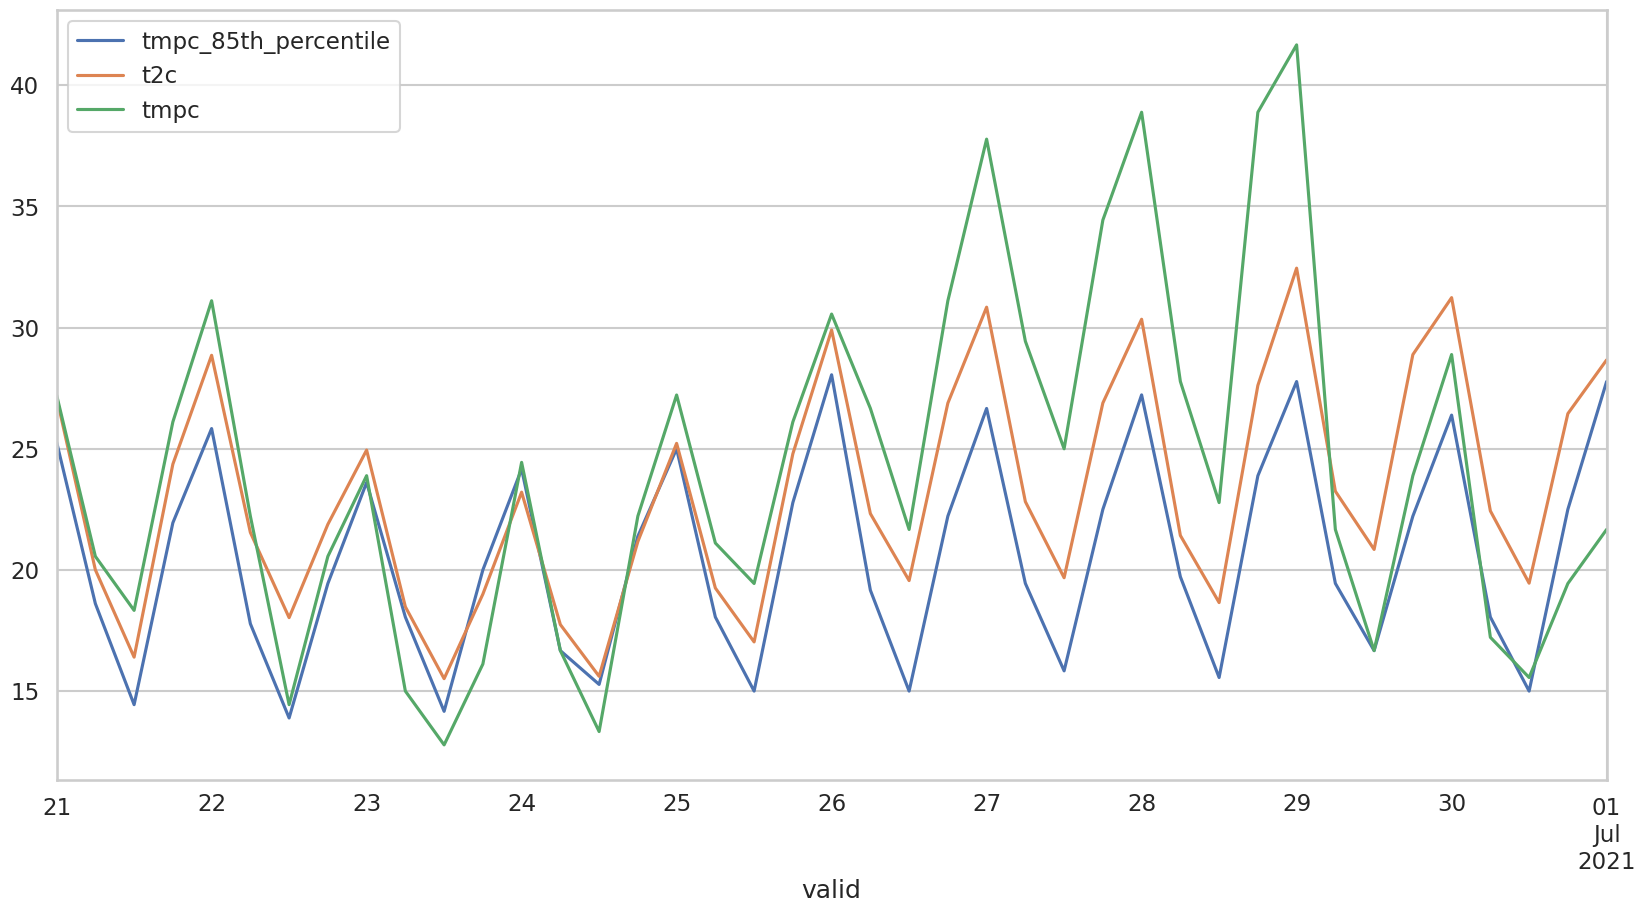

In [69]:
ksea_merged_df[ksea_merged_df['init_time']=='2021-06-21'].plot(y=['tmpc_85th_percentile','t2c','tmpc'], x='valid', figsize=(20,10))

In [70]:
filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']])

/tmp/ipykernel_2302/2380073977.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']])


index               valid  latitude  longitude  \
init_time                                                                   
2021-06-21 00:00:00 403      136 2021-06-24 06:00:00      47.5     237.75   
                    434      137 2021-06-24 12:00:00      47.5     237.75   
                    496      139 2021-06-25 00:00:00      47.5     237.75   
                    527      140 2021-06-25 06:00:00      47.5     237.75   
                    558      141 2021-06-25 12:00:00      47.5     237.75   
...                          ...                 ...       ...        ...   
2021-07-03 12:00:00 32891   4259 2021-07-12 12:00:00      47.5     237.75   
                    32922   4260 2021-07-12 18:00:00      47.5     237.75   
                    32953   4261 2021-07-13 00:00:00      47.5     237.75   
                    32984   4262 2021-07-13 06:00:00      47.5     237.75   
                    33015   4263 2021-07-13 12:00:00      47.5     237.75   

                                  t2 stationid  fhour           init_time  \
init_time                                                                   
2021-06-21 00:00:00 403    290.89438      KSEA   78.0 2021-06-21 00:00:00   
                    434    288.76035      KSEA   84.0 2021-06-21 00:00:00   
                    496    298.37400      KSEA   96.0 2021-06-21 00:00:00   
                    527    292.40290      KSEA  102.0 2021-06-21 00:00:00   
                    558    290.17862      KSEA  108.0 2021-06-21 00:00:00   
...                              ...       ...    ...                 ...   
2021-07-03 12:00:00 32891  291.29153      KSEA  216.0 2021-07-03 12:00:00   
                    32922  300.01514      KSEA  222.0 2021-07-03 12:00:00   
                    32953  303.31104      KSEA  228.0 2021-07-03 12:00:00   
                    32984  294.71118      KSEA  234.0 2021-07-03 12:00:00   
                    33015  291.88700      KSEA  240.0 2021-07-03 12:00:00   

                                t2c       tmpc month_day_hour  \
init_time                                                       
2021-06-21 00:00:00 403    17.74438  16.670000       06-24 06   
                    434    15.61035  13.330000       06-24 12   
                    496    25.22400  27.220000       06-25 00   
                    527    19.25290  21.110000       06-25 06   
                    558    17.02862  19.440000       06-25 12   
...                             ...        ...            ...   
2021-07-03 12:00:00 32891  18.14153  12.780000       07-12 12   
                    32922  26.86514  21.670000       07-12 18   
                    32953  30.16104  26.670000       07-13 00   
                    32984  21.56118  18.330000       07-13 06   
                    33015  18.73700  12.593333       07-13 12   

                           tmpc_85th_percentile  
init_time                                        
2021-06-21 00:00:00 403                  16.670  
                    434                  15.275  
                    496                  25.000  
                    527                  18.055  
                    558                  15.000  
...                                         ...  
2021-07-03 12:00:00 32891                16.390  
                    32922                24.445  
                    32953                28.690  
                    32984                20.835  
                    33015                16.670  

[569 rows x 12 columns]

In [65]:
# Group by 'init_time' and find the first 'valid' where 't2c' is greater than 'tmpc_85th_percentile'
result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']].iloc[0])
result

/tmp/ipykernel_2302/2755532395.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['tmpc_85th_percentile']].iloc[0])


,index,valid,latitude,longitude,t2,stationid,fhour,init_time,t2c,tmpc,month_day_hour,tmpc_85th_percentile
init_time,,,,,,,,,,,,
2021-06-21 00:00:00,136,2021-06-24 06:00:00,47.5,237.75,290.89438,KSEA,78.0,2021-06-21 00:00:00,17.74438,16.67,06-24 06,16.670
2021-06-21 12:00:00,298,2021-06-24 06:00:00,47.5,237.75,290.06342,KSEA,66.0,2021-06-21 12:00:00,16.91342,16.67,06-24 06,16.670
2021-06-22 00:00:00,460,2021-06-24 06:00:00,47.5,237.75,290.95270,KSEA,54.0,2021-06-22 00:00:00,17.80270,16.67,06-24 06,16.670
2021-06-22 12:00:00,627,2021-06-25 12:00:00,47.5,237.75,289.70828,KSEA,72.0,2021-06-22 12:00:00,16.55828,19.44,06-25 12,15.000
2021-06-23 00:00:00,784,2021-06-24 06:00:00,47.5,237.75,291.38998,KSEA,30.0,2021-06-23 00:00:00,18.23998,16.67,06-24 06,16.670
2021-06-23 12:00:00,951,2021-06-25 12:00:00,47.5,237.75,288.34580,KSEA,48.0,2021-06-23 12:00:00,15.19580,19.44,06-25 12,15.000
2021-06-24 00:00:00,1108,2021-06-24 06:00:00,47.5,237.75,293.06450,KSEA,6.0,2021-06-24 00:00:00,19.91450,16.67,06-24 06,16.670
2021-06-24 12:00:00,1274,2021-06-25 06:00:00,47.5,237.75,291.37198,KSEA,18.0,2021-06-24 12:00:00,18.22198,21.11,06-25 06,18.055
2021-06-25 00:00:00,1435,2021-06-25 00:00:00,47.5,237.75,300.23170,KSEA,0.0,2021-06-25 00:00:00,27.08170,27.22,06-25 00,25.000


In [14]:
# Filter the dataframe for dates after June 26 00Z, the start of the heatwave
filtered_df_below = ksea_merged_df[ksea_merged_df['valid'] > '2021-06-26 00:00:00']

# Group by 'init_time' and find the first 'valid' where 't2c' is less than '85th_percentile_by_hour'
result_below = filtered_df_below.groupby('init_time').apply(lambda x: x[x['t2c'] < x['85th_percentile_by_hour']].iloc[0] if not x[x['t2c'] < x['85th_percentile_by_hour']].empty else pd.Series([np.nan]*x.shape[1], index=x.columns))
# Drop empty rows
result_below = result_below.dropna().reset_index(drop=True)

# Find the first time ksea_event_df's 'tmpc' was less than '85th_percentile_by_hour'
first_below_time = ksea_event_df_subset[(ksea_event_df_subset['tmpc'] < ksea_event_df_subset['85th_percentile_by_hour']) & (ksea_event_df_subset['valid'] > '2021-06-26 00:00:00')].min()['valid']

# Ensure first_below_time is a Timestamp object
first_below_time = pd.to_datetime(first_below_time)

# Calculate the time difference and create the 'end_error' column
result_below['end_error'] = result_below['valid'] - first_below_time

/tmp/ipykernel_18938/2688367609.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_below = filtered_df_below.groupby('init_time').apply(lambda x: x[x['t2c'] < x['85th_percentile_by_hour']].iloc[0] if not x[x['t2c'] < x['85th_percentile_by_hour']].empty else pd.Series([np.nan]*x.shape[1], index=x.columns))


In [71]:
ksea_merged_df

,index,valid,latitude,longitude,t2,stationid,fhour,init_time,t2c,tmpc,month_day_hour,tmpc_85th_percentile
0,123,2021-06-21 00:00:00,47.5,237.75,300.27658,KSEA,0.0,2021-06-21 00:00:00,27.12658,27.220000,06-21 00,25.280
31,124,2021-06-21 06:00:00,47.5,237.75,293.15503,KSEA,6.0,2021-06-21 00:00:00,20.00503,20.560000,06-21 06,18.610
62,125,2021-06-21 12:00:00,47.5,237.75,289.55127,KSEA,12.0,2021-06-21 00:00:00,16.40127,18.330000,06-21 12,14.440
93,126,2021-06-21 18:00:00,47.5,237.75,297.51520,KSEA,18.0,2021-06-21 00:00:00,24.36520,26.110000,06-21 18,21.945
124,127,2021-06-22 00:00:00,47.5,237.75,302.00930,KSEA,24.0,2021-06-21 00:00:00,28.85930,31.110000,06-22 00,25.835
...,...,...,...,...,...,...,...,...,...,...,...,...
32891,4259,2021-07-12 12:00:00,47.5,237.75,291.29153,KSEA,216.0,2021-07-03 12:00:00,18.14153,12.780000,07-12 12,16.390
32922,4260,2021-07-12 18:00:00,47.5,237.75,300.01514,KSEA,222.0,2021-07-03 12:00:00,26.86514,21.670000,07-12 18,24.445
32953,4261,2021-07-13 00:00:00,47.5,237.75,303.31104,KSEA,228.0,2021-07-03 12:00:00,30.16104,26.670000,07-13 00,28.690
32984,4262,2021-07-13 06:00:00,47.5,237.75,294.71118,KSEA,234.0,2021-07-03 12:00:00,21.56118,18.330000,07-13 06,20.835


In [17]:
merged_result = pd.merge(result, result_below, on='init_time', suffixes=('_above', '_below'))
merged_result['time_mae'] = (merged_result['begin_error'].abs() + merged_result['end_error'].abs())/2
merged_result['time_me'] = (merged_result['begin_error'] + merged_result['end_error'])/2
merged_result['time_mae_hours'] = merged_result['time_mae'].dt.total_seconds() / 3600
merged_result['begin_time_hours'] = merged_result['begin_error'].dt.total_seconds() / 3600
merged_result['end_time_hours'] = merged_result['end_error'].dt.total_seconds() / 3600
merged_result['time_me_hours'] = merged_result['time_me'].dt.total_seconds() / 3600

Text(0.5, 1.0, 'Event Duration MAE (hours)')

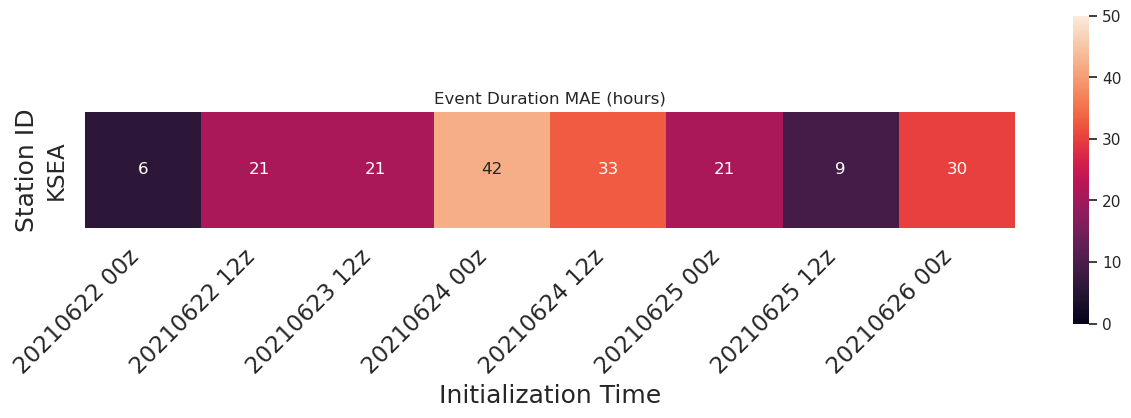

In [ ]:
merged_pivot = merged_result.pivot(index='stationid_above', columns='init_time', values='time_mae_hours')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=0, vmax=50, square=True)
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Station ID')
ax.set_xlabel('Initialization Time')
ax.set_title('Event Duration MAE (hours)')

Text(0.5, 1.0, 'Event Duration ME (hours)')

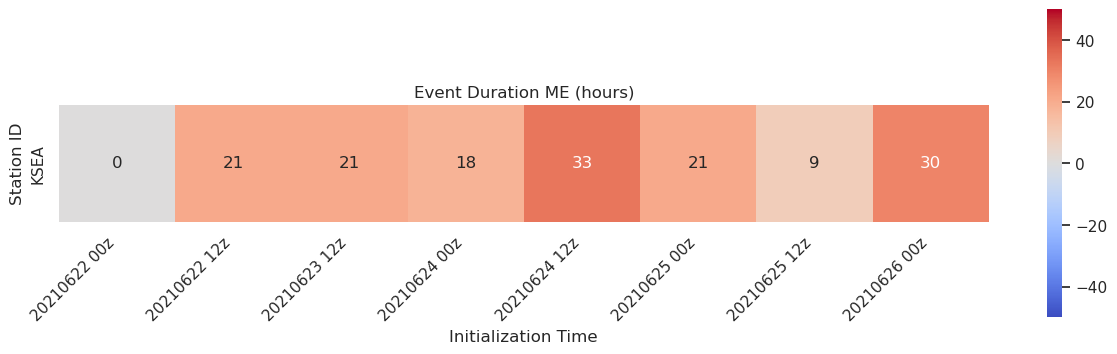

In [20]:
merged_pivot = merged_result.pivot(index='stationid_above', columns='init_time', values='time_me_hours')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=-50, vmax=50, square=True, cmap='coolwarm')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Station ID')
ax.set_xlabel('Initialization Time')
ax.set_title('Event Duration ME (hours)')

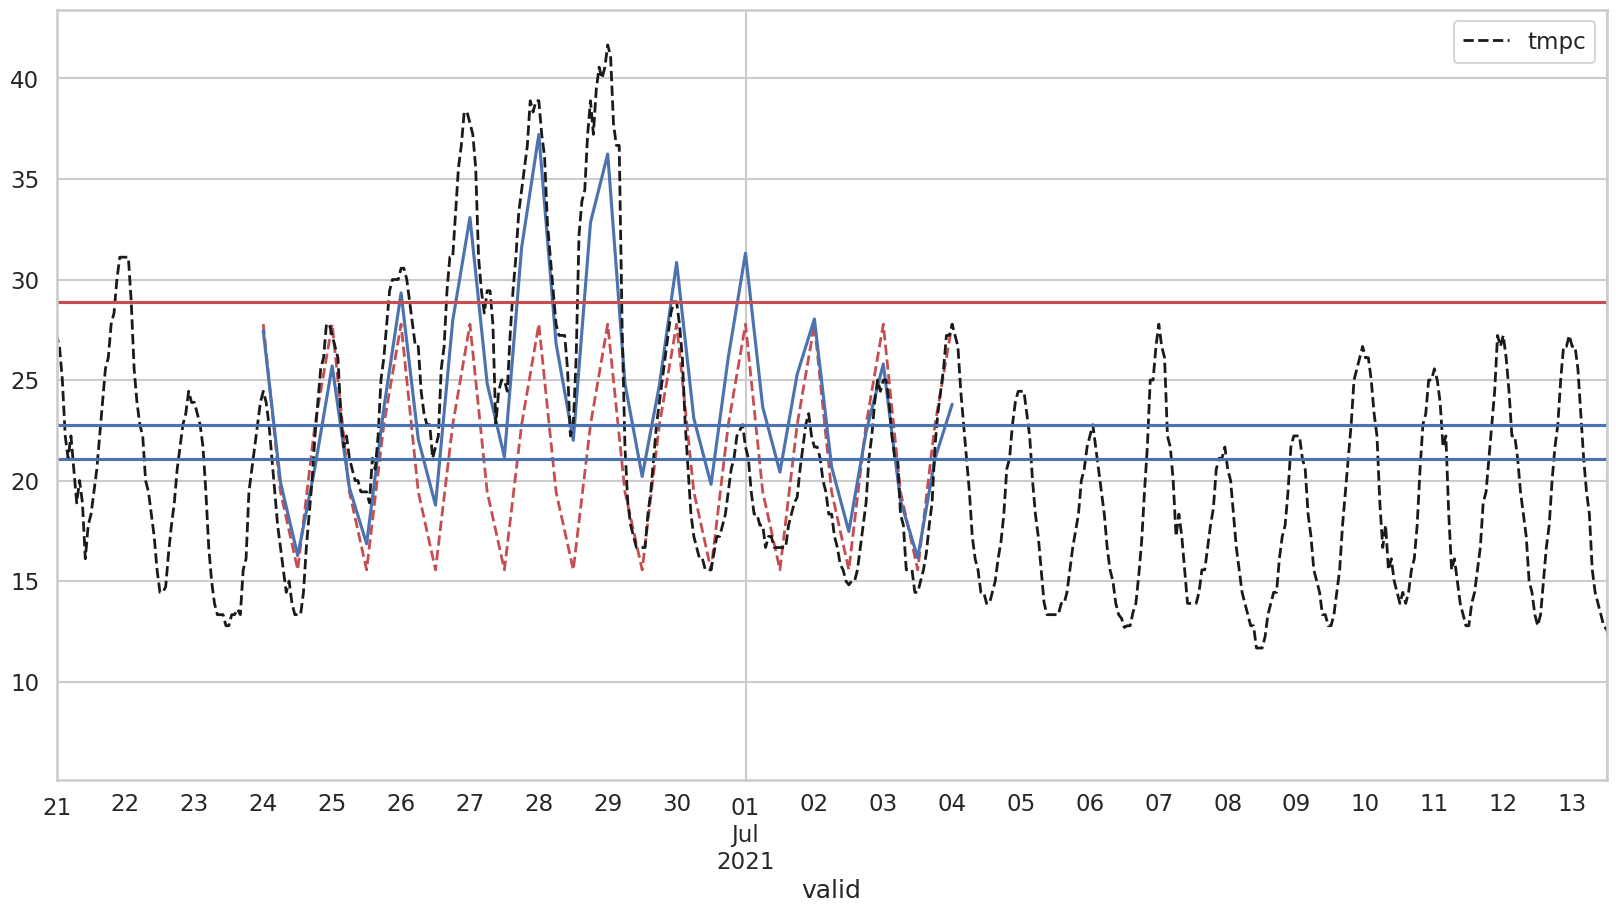

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-24 00'].plot(x='valid',y='tmpc_85th_percentile',ls='--',lw=2,c='r',ax=ax,legend=False)
ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-24 00'].plot(x='valid',y='t2c',ax=ax,legend=False)
ksea_event_df.plot(y='tmpc',ls='--',lw=2,c='k',ax=ax)
ax.set_xlim(ksea_merged_df['valid'].min(),ksea_merged_df['valid'].max())
ax.axhline(climatology_dict['KSEA']['temp_85th_percentile'])
ax.axhline(climatology_dict['KSEA']['mean_temp_85th_percentile'])
ax.axhline(climatology_dict['KSEA']['max_temp_85th_percentile'],c='r')

plt.show()

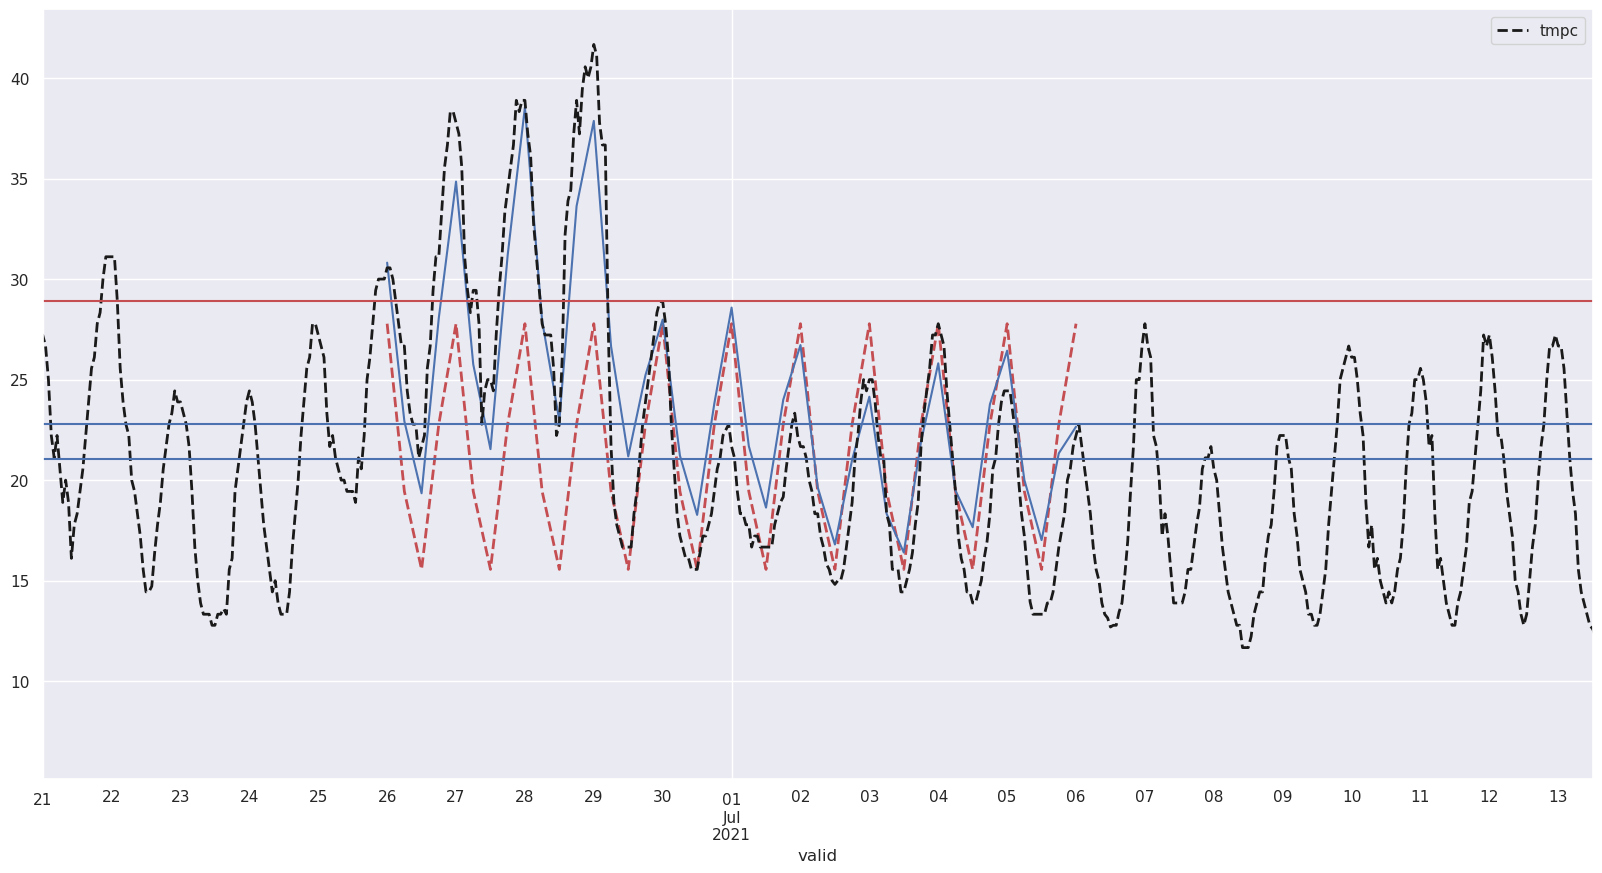

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-26 00'].plot(x='valid',y='tmpc_85th_percentile',ls='--',lw=2,c='r',ax=ax,legend=False)
ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-26 00'].plot(x='valid',y='t2c',ax=ax,legend=False)
ksea_event_df.plot(y='tmpc',ls='--',lw=2,c='k',ax=ax)
ax.set_xlim(ksea_merged_df['valid'].min(),ksea_merged_df['valid'].max())
ax.axhline(climatology_dict['KSEA']['temp_85th_percentile'])
ax.axhline(climatology_dict['KSEA']['mean_temp_85th_percentile'])
ax.axhline(climatology_dict['KSEA']['max_temp_85th_percentile'],c='r')